In this notebook, we'll be implementing the Transformer-XL architecture from scratch.
To run this notebook in full, make sure to use the `download_data.sh` script to download the Penn Treebank data.

In [1]:
from typing import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

# Review of the Transformer

Let's start off with a quick overview of the Transformer architecture which will be the basis of the Transformer XL.

Overall, the Transformer architecture is composed of multiple MultiHeadAttention layer stacked on top of each other, followed by feedforward layers, residual connections, and layer normalization layers.

![image](https://camo.githubusercontent.com/88e8f36ce61dedfd2491885b8df2f68c4d1f92f5/687474703a2f2f696d6775722e636f6d2f316b72463252362e706e67)

The MultiHeadAttention layer is composed of multiple attention heads. Each attention head applies a linear transformation to its inputs and computes attention over its input values using keys and queries.

![image](https://i2.wp.com/mlexplained.com/wp-content/uploads/2017/12/multi_head_attention.png?zoom=2&resize=224%2C293)

This approach is incapable of handling position, so the Transformer adds embeddings representing the position of the input to the word embeddings.

For more details, please refer to [this tutorial](https://github.com/keitakurita/Practical_NLP_in_PyTorch/blob/master/deep_dives/transformer_from_scratch.ipynb) I've written on just the Transformer.

We'll be building the Transformer XL by first implementing a single attention head, scaling it to compose the MultiHeadAttention layer for the Transformer XL, then building the DecoderBlock and stacking them to create the full Transformer XL.

# Implementing the Transformer XL

### A Single Attention Head

We'll start off by implementing a single attention head in a MultiHeadAttention layer. To make things concrete, let's consider the first layer and assume we receive an input of word embeddings of shape `(seq=7, batch_size=3, embedding_dim=32)`. Note that the Transformer XL does not add positional embeddings to the input.

In [3]:
seq, batch_size, embedding_dim = 7, 3, 32

In [4]:
word_embs = torch.rand(seq, batch_size, embedding_dim)

In the Transformer XL, we also feed the cached outputs of the model for the previous sequence. In this case, we would be feeding the word embeddings from the previous sequence as an additional input to our model.

![image](https://4.bp.blogspot.com/-Do42uKiMvKg/XFCns7oXi5I/AAAAAAAADuc/ZS-p1XHZUNo3K9wv6nRG5AmdEK7mJsrugCLcBGAs/s1600/xl-eval.gif)

To make things concrete, let's imagine our previous sequence was of length `prev_seq=6`

In [5]:
prev_seq = 6
memory = torch.rand(prev_seq, batch_size, embedding_dim) # hidden states from the previous sequence

Each attention head takes keys, queries, and values as input. The processing goes like this:

1. Apply a separate linear transformation to each of the keys, queries, and values.
2. Compute attention scores for each of the values.
3. For each query, compute an attention-weighted sum of the values.
4. Apply a residual connection and layer normalization.

We'll start off with the linear transformation.

In [6]:
inner_dim = 17 # this will be the internal dimension
linear_k = nn.Linear(embedding_dim, inner_dim)
linear_v = nn.Linear(embedding_dim, inner_dim)
linear_q = nn.Linear(embedding_dim, inner_dim)

The memory is concatenated across the sequence dimension and fed as keys/values. Be careful, as it's not concatenated with the queries. This is because each query represents one word we want to predict, so we can't modify the number of queries.

In [7]:
word_embs_w_memory = torch.cat([memory, word_embs], dim=0)
k_tfmd = linear_k(word_embs_w_memory)
v_tfmd = linear_v(word_embs_w_memory)
q_tfmd = linear_q(word_embs) # No memory for the queries

Now, we compute scaled dot product attention as per the usual Transformer. Scaled dot product attention computes the attention score as the dot product between the query and key vectors. To prevent the values from exploding as the dimensionality of the vectors increases, we divide the raw attention score by the sqrt of the embedding size.

$$ \textrm{Attention}(Q, K, V) = \textrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V $$

![image](https://i2.wp.com/mlexplained.com/wp-content/uploads/2017/12/scaled_dot_product_attention.png?zoom=2&w=750)

We'll be using einsum notation here to make the code easy to read: if you're not familiar with einsum, check out [this awesome tutorial](https://rockt.github.io/2018/04/30/einsum). In short, einsum denotes the shape of the inputs and outputs using one letter to represent each dimension. Below, the inputs are shaped `(i, b, d)` and `(j, b, d)` and the output is shaped `(i, j, b)` where the same letter represents the same size. Einsum is computed by taking the dot product across dimensions with the same character.

In [8]:
content_attn = torch.einsum("ibd,jbd->ijb", q_tfmd, k_tfmd) / (embedding_dim ** 0.5) # scale

Notice we're not yet applying the softmax activation. This is because we need a couple more pieces to get the full attention score. The first of these is the relative positional embeddings.

### Relative positional encodings

One of the key ideas in the Transformer XL is the idea of relative positional encodings. Instead of having a single embedding represent each **absolute** position, the Transformer XL computes an embedding that represents the **distance** between any two tokens. This is used to compute the attention between the two words.

The authors use the following equation to compute the attention between a query vector $ q_i $ and key vector $k_j$:

\begin{align}
A^{rel}_{i,j} = 
    \underbrace{E_{x_i}^TW_q^TW_{k,E}E_{x_j}}_{(a)}
    + \underbrace{E_{x_i}^TW_q^TW_{k,R} \color{green}R_\color{green}{i-j} }_{(b)}
    \\ 
    + \underbrace{ \color{red}u^\color{red}T W_{k,E}E_{x_j}}_{(c)} 
    + \underbrace{ \color{red}v^\color{red}T W_{k,R} \color{green}R_\color{green}{i-j}}_{(d)}
\end{align}

Here, $E_{x}$ is the embedding for $ x $ and $ W $ are all transformation matrices. The (a) term is the content-based attention terms that we already computed above. (b) and (d) are based on the relative positional embeddings and are dependent on the distance between $q_i$ and $k_j$. $u$ and $v$ are global bias terms that represent biases for certain content and certain positions.

Let's move on to the detailed implementation of terms (b) to (d). We'll first add the content bias (term (c) in the above equation) since it is the most simple to compute.

In [9]:
u = torch.rand(17).expand_as(q_tfmd)
content_attn = content_attn + torch.einsum("ibd,jbd->ijb", u, k_tfmd) / (embedding_dim ** 0.5)

Next, we compute the relative positional embeddings necessary for the positional attention terms. For the relative positional embeddings, the Transformer XL uses fixed sinusoidal embeddings.

In [10]:
pos_idxs = torch.arange(seq + prev_seq - 1, -1, -1.0, dtype=torch.float)
pos_idxs

tensor([12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.])

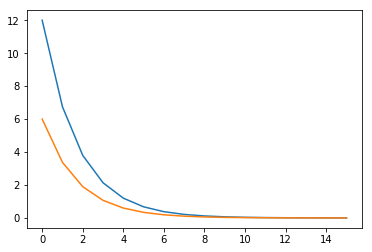

In [11]:
inv_freq = 1 / (10000 ** (torch.arange(0.0, embedding_dim, 2.0) / embedding_dim))
sinusoid_inp = torch.einsum("i,j->ij", pos_idxs, inv_freq)
plt.plot(sinusoid_inp[0, :].detach().numpy());
plt.plot(sinusoid_inp[6, :].detach().numpy());

In [12]:
relative_positional_embeddings = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)[:,None,:]
relative_positional_embeddings.shape

torch.Size([13, 1, 32])

Now, we can gather this into its own class

In [13]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        inv_freq = 1 / (10000 ** (torch.arange(0.0, d, 2.0) / d))
        # register buffer tells pytorch that this tensor is part of the modle
        # this means that it will be saved in the state_dict and moved to the GPU
        # along with the model
        self.register_buffer("inv_freq", inv_freq)
        
    def forward(self, positions: torch.LongTensor, # (seq, )
               ):
        # outer product
        sinusoid_inp = torch.einsum("i,j->ij", positions.float(), self.inv_freq)
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)
        return pos_emb[:,None,:]

We also apply transformations to the positional embeddings separate from the values/keys.

In [14]:
linear_p = nn.Linear(embedding_dim, inner_dim)
pos_tfmd = linear_p(relative_positional_embeddings)

This time, we'll be adding the positional bias during attention computation.

In [15]:
v = torch.rand(17) # positional bias
pos_attn = torch.einsum("ibd,jd->ijb", q_tfmd + v, pos_tfmd[:,0,:]) / (embedding_dim ** 0.5) # scale
pos_attn.shape

torch.Size([7, 13, 3])

Since we compute a relative postional embedding for each key-query pair, a naive implementation of attention using relative positional embeddings would be $O(n^2)$ in terms of computational complexity. Luckily, the authors proposed a trick to reduce this to $O(n)$ time by computing the attention for one query then shifting the embeddings for different query positions..

In [16]:
zero_pad = torch.zeros((seq, 1, batch_size), dtype=torch.float)
# this padding + shifting efficiently computes the attention for all 
pos_attn = (torch.cat([zero_pad, pos_attn], dim=1)
                    .view(seq + prev_seq + 1, seq, batch_size)[1:]
                    .view_as(pos_attn)) 

The attention is computed as the sum of content and positional attention.

In [17]:
raw_attn = content_attn + pos_attn

When we do language modeling, we need to prevent the model from being able to look at the word that it is supposed to be predicting. In the Transformer, we achieve this by setting the attention score to zero. This masks out words that we don't want the model to be able to see. 

In [18]:
mask = torch.triu(
    torch.ones((seq, seq + prev_seq)),
    diagonal=1 + prev_seq,
).byte()[...,None]
raw_attn = raw_attn.masked_fill(mask, -float('inf'))

We can now compute the outputs as the weighted sum of the value vectors using the attention scores.

In [19]:
attn = torch.softmax(raw_attn, dim=1)
attn_weighted_sum = torch.einsum("ijb,jbd->ibd", attn, v_tfmd)
attn_weighted_sum.shape

torch.Size([7, 3, 17])

Finally, we project the attention weighted sums back to their original dimension and apply a residual connection and layer normalization. We apply layer normalization after the residual connection.

In [20]:
linear_out = nn.Linear(inner_dim, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
output = layer_norm(word_embs + linear_out(attn_weighted_sum))
output.shape

torch.Size([7, 3, 32])

### MultiHeadAttention (MHA): The core component

Aggregating all the above and applying a couple of optimizations by grouping some computations together as well as adding dropout, we get the following MultiHeadAttention module.

In [21]:
from typing import *

class MultiHeadAttention(nn.Module):
    def __init__(self, d_input: int, d_inner: int, n_heads: int=4, 
                 dropout: float=0.1, dropouta: float=0.):
        super().__init__()
        self.d_input = d_input
        self.d_inner = d_inner
        self.n_heads = n_heads
        # this layer applies the linear transformation required
        # for the keys and values for all heads at once for efficiency
        self.linear_kv = nn.Linear(
            d_input, 
            (d_inner * n_heads * 2), # 2 is for keys and values
            bias=False, # we don't apply bias, making this a simple matrix multiplication
        )
        # for queries (will not be concatenated with memorized states so separate)
        self.linear_q = nn.Linear(
            d_input, d_inner * n_heads,
            bias=False
        )
        # for positional embeddings
        self.linear_p = nn.Linear(
            d_input, d_inner * n_heads,
            bias=False
        )
        self.scale = 1 / (d_inner ** 0.5) # for scaled dot product attention
        self.dropa = nn.Dropout(dropouta)
        # we will use this to project back to the input dimension
        self.lout = nn.Linear(self.d_inner * self.n_heads, self.d_input, bias=False)
        self.norm = nn.LayerNorm(self.d_input)
        self.dropo = nn.Dropout(dropout)
        
    def _rel_shift(self, x):
        zero_pad = torch.zeros((x.size(0), 1, *x.size()[2:]),
                               device=x.device, dtype=x.dtype)
        return (torch.cat([zero_pad, x], dim=1)
                    .view(x.size(1) + 1, x.size(0), *x.size()[2:])[1:]
                    .view_as(x)) 
        
    def forward(self, input_: torch.FloatTensor, # (cur_seq, b, d_in)
                pos_embs: torch.FloatTensor, # (cur_seq + prev_seq, d_in)
                memory: torch.FloatTensor, # (prev_seq, b, d_in)
                u: torch.FloatTensor, # (H, d)
                v: torch.FloatTensor, # (H, d)
                mask: Optional[torch.FloatTensor]=None,
        ):
        """
        pos_embs: we pass the positional embeddings in separately
            because we need to handle relative positions
        input shape: (seq, bs, self.d_input)
        pos_embs shape: (seq + prev_seq, bs, self.d_input)
        output shape: (seq, bs, self.d_input)
        """
        cur_seq = input_.shape[0] #  sequence length of current segment
        prev_seq = memory.shape[0] # sequence length of previous segment
        H, d = self.n_heads, self.d_inner
        input_with_memory = torch.cat([memory, input_], dim=0) # concatenate recurrent memory
                                                               # across sequence dimension

        # we will use the following symbols to represent the shape of the tensors
        # cs: current sequence length, b: batch, H: number of heads
        # d: inner dimension, ps: previous sequence length
        # The key and value are now conditioned on the preceding context
        k_tfmd, v_tfmd = \
            torch.chunk(self.linear_kv(input_with_memory), 2, dim=-1) # (cs + ps, b, H * d)
        q_tfmd = self.linear_q(input_) # (cs, b, H * d)

        # apply scaled dot product attention
        # look at the following dimensions carefully, since this is the key operation
        # in the Transformer/Transformer XL architecture
        
        _, bs, _ = q_tfmd.shape
        assert bs == k_tfmd.shape[1]
        # content-based attention term ((a) + (c) in the paper)
        # this is the standard attention term in the original Transformer, except without positional embeddings
        # which are handled separately in the Transformer XL (see below)
        # here, i corresponds to the number of queries = number of current inputs/targets (seq-wise)
        # j corresponds to the number of key/values = number of vectors that we can use to compute the 
        # vector for each query
        content_attn = torch.einsum("ibhd,jbhd->ijbh", (
                (q_tfmd.view(cur_seq, bs, H, d) + # (a)
                 u), # (c): u represents the global (independent of the query)
                     # bias towards certain key/values = words
                     # Note: maybe this could be a per-attention head parameter?
                 k_tfmd.view(cur_seq + prev_seq, bs, H, d) # There is no positional information to be found here
        )) # (cs, cs + ps, b, H)
        
        # position-based attention term ((b) + (d) in the paper)
        # this attention is solely based on the position of the key/values
        # (i.e. it does not take the content of the key/values into account)
        p_tfmd = self.linear_p(pos_embs) # (cs + ps, b, H * d)
        position_attn = torch.einsum("ibhd,jhd->ijbh", (
                (q_tfmd.view(cur_seq, bs, H, d) + # (b)
                 v), # (d): v represents the global (independent of the query)
                     # bias towards certain positions
                 p_tfmd.view(cur_seq + prev_seq, H, d) # Notice there is not content information
                                                        # regarding keys and values here!
        )) # (cs, cs + ps, b, H)
        
        #  Compute positional attention efficiently
        position_attn = self._rel_shift(position_attn)
        
        # the attention is the sum of content-based and position-based attention
        attn = content_attn + position_attn

        if mask is not None and mask.any().item():
            attn = attn.masked_fill(
                mask[...,None], -float('inf'))
        attn = torch.softmax(attn * self.scale, # rescale to prevent values from exploding
                             dim=1) # normalize across the value sequence dimension
        attn = self.dropa(attn)
        
        attn_weighted_values = (torch.einsum("ijbh,jbhd->ibhd",
                                           (attn, # (cs, cs + ps, b, H)
                                            v_tfmd.view(cur_seq + prev_seq, bs, H, d), # (cs + ps, b, H, d)
                                           )) # (cs, b, H, d)
                                .contiguous() # we need to change the memory layout to make `view` work
                                .view(cur_seq, bs, H * d)) # (cs, b, H * d)

        # Project back to input dimension and add residual connection
        output = input_ + self.dropo(self.lout(attn_weighted_values))
        output = self.norm(output)
        return output

Let's test it out to see if it runs successfully

In [22]:
mha = MultiHeadAttention(32, 17, n_heads=4)

In [23]:
inpt = torch.rand(7, 3, 32)
pos = torch.rand(13, 32)
mem = torch.rand(6, 3, 32)
u, v = torch.rand(4, 17), torch.rand(4, 17)
x1 = mha(inpt, pos, mem, u, v)

Looks good

In [24]:
x1.shape

torch.Size([7, 3, 32])

In [25]:
x1[0]

tensor([[ 0.6264,  0.3405, -1.9065,  0.1543,  0.0389, -1.6033,  1.4415,  0.4983,
          0.7548,  1.0990, -1.1783, -1.3847, -1.7358,  1.4651,  1.0633,  0.2168,
         -0.3323,  1.1270,  0.1614,  1.0170,  1.0459, -0.7286,  0.5064, -1.4765,
          0.0448, -1.2500,  0.3132, -0.8007,  0.4089,  0.7325, -1.2740,  0.6147],
        [ 0.9541,  0.3682, -0.8096,  0.1357, -0.9159, -1.4382, -1.3385,  0.8269,
          0.2721, -0.4982,  1.3105, -0.0236, -1.0547, -1.3076,  1.8884, -0.2891,
          1.5231,  0.5507, -0.6423,  0.4412,  1.3656,  0.7858, -0.9425, -0.3198,
         -0.3162, -0.0086,  1.5257, -1.3216,  1.4492, -0.1750, -0.1669, -1.8291],
        [ 1.0132,  0.7205, -0.4221,  0.2952, -1.4117, -0.6182, -1.7520, -1.7426,
         -0.4648, -0.2122,  2.0889, -1.3544, -0.1611, -1.0696,  1.3492, -1.0179,
          1.2820,  0.8990,  0.7411,  0.8052, -0.5322,  0.6277, -0.2733, -1.0738,
         -0.8435,  1.5357,  0.8260, -0.3422, -0.6204,  1.0091,  0.1011,  0.6182]],
       grad_fn=<SelectBa

### Building the decoder

To construct the decoder block, all we need in addition to the MultiHeadAttention layer is the Positionwise Feed Forward layer.

![image](https://i2.wp.com/mlexplained.com/wp-content/uploads/2017/12/%E3%82%B9%E3%82%AF%E3%83%AA%E3%83%BC%E3%83%B3%E3%82%B7%E3%83%A7%E3%83%83%E3%83%88-2017-12-29-19.14.41.png?w=273)

In [26]:
class PositionwiseFF(nn.Module):
    def __init__(self, d_input, d_inner, dropout):
        super().__init__()

        self.d_input = d_input
        self.d_inner = d_inner
        self.dropout = dropout
        self.ff = nn.Sequential(
            nn.Linear(d_input, d_inner), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_inner, d_input),
            nn.Dropout(dropout),
        )
        self.layer_norm = nn.LayerNorm(d_input)

    def forward(self, input_: torch.FloatTensor, # (cur_seq, bs, d_input)
               ) -> torch.FloatTensor: # (cur_seq, bs, d_input)
        ff_out = self.ff(input_)
        output = self.layer_norm(input_ + ff_out)
        return output

Now we can implement the decoder block.

In [27]:
class DecoderBlock(nn.Module):
    def __init__(self, n_heads, d_input, 
                 d_head_inner, d_ff_inner,
                 dropout, dropouta=0.):
        super().__init__()
        self.mha = MultiHeadAttention(d_input, d_head_inner, n_heads=n_heads, 
                                      dropout=dropout, dropouta=dropouta)
        self.ff = PositionwiseFF(d_input, d_ff_inner, dropout)
            
    def forward(self, input_: torch.FloatTensor, # (cur_seq, bs, d_input)
                pos_embs: torch.FloatTensor, # (cur_seq + prev_seq, d_input),
                u: torch.FloatTensor, # (H, d_input), 
                v: torch.FloatTensor, # (H, d_input),
                mask=None,
                mems=None,
               ):
        return self.ff(self.mha(input_, pos_embs, mems, u, v, mask=mask))

### The full Transformer XL

In [28]:
import torch.nn.functional as F

Now with these components in place, we can build the full Transformer XL model.

Aside from what we mentioned above, one common trick in language modeling that we haven't covered yet is tying the input embedding matrix $ E $ and output projection matrix $ P $. Remember, a language model predicts the next token in a sequence, so its output dimension is $\mathbb{R}^{|V|}$  where $|V|$ is the vocab size. If we constrain the penultimate layer output to be the same dimension as the embeddings $d$, the embedding matrix $ E $ will be of shape $ \mathbb{R}^{|V| \times d}$ and the output projection matrix $ P $ will be of shape $ \mathbb{R}^{d \times |V|} $.

In [this paper](https://arxiv.org/abs/1608.05859), the authors found that constraining the matrices such that $ P = E^T $ improved performance while greatly reducing the total parameter count (and thus memory usage!) of the model.

Instead of simply using the exact same weights, we scale the embeddings by the embedding dim. This trick is included in the codebase but not mentioned in the paper as far as I can tell. If you're aware of a paper where this trick was originally introduced, please let me know!

In [29]:
class StandardWordEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim,
                div_val=1, sample_softmax=False):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.scale = embedding_dim ** 0.5

    def forward(self, input_: torch.LongTensor):
        return self.embedding(input_) * self.scale

Now, all we need to do is to put everything we have implemented above together.

In [30]:
class TransformerXL(nn.Module):
    def __init__(self, num_embeddings, n_layers, n_heads, 
                 d_model, d_head_inner, d_ff_inner,
                 dropout=0.1, dropouta=0., 
                 seq_len: int=0, mem_len: int=0):
        super().__init__()
        self.n_layers,self.n_heads,self.d_model,self.d_head_inner,self.d_ff_inner = \
            n_layers,n_heads,d_model,d_head_inner,d_ff_inner
        # Embedding layers
        self.word_embs = StandardWordEmbedding(num_embeddings, d_model)
        self.pos_embs = PositionalEmbedding(d_model)
        # Core transformer
        self.drop = nn.Dropout(dropout)
        self.layers = nn.ModuleList([DecoderBlock(n_heads, d_model, d_head_inner=d_head_inner,
                                                  d_ff_inner=d_ff_inner,
                                                  dropout=dropout, dropouta=dropouta)
                                     for _ in range(n_layers)])

        # tie weights
        self.output_projection = nn.Linear(d_model, num_embeddings)
        self.output_projection.weight = self.word_embs.embedding.weight
        self.loss_fn = nn.CrossEntropyLoss()

        self.seq_len, self.mem_len = seq_len, mem_len
        
        # u and v are global parameters: maybe changing these to per-head parameters
        # might help performance?
        self.u, self.v = (nn.Parameter(torch.Tensor(self.n_heads, self.d_head_inner)),
                          nn.Parameter(torch.Tensor(self.n_heads, self.d_head_inner)))
        
    def init_memory(self, device=torch.device("cpu")) -> torch.FloatTensor:
        return [torch.empty(0, dtype=torch.float).to(device) for _ in range(self.n_layers+1)]
    
    def update_memory(self, 
            previous_memory: List[torch.FloatTensor], 
            hidden_states: List[torch.FloatTensor],
        ):
        assert len(hidden_states) == len(previous_memory)
        mem_len, seq_len = previous_memory[0].size(0), hidden_states[0].size(0)

        # For the updated memory, we use the most recent `self.mem_len`
        # states, including the previous memory
        # In other words, if `seq_len` < `self.mem_len` some of the previous memory
        # will carry over to the next memory
        with torch.no_grad():
            new_memory = []
            end_idx = mem_len + seq_len
            beg_idx = max(0, end_idx - self.mem_len)
            for m, h in zip(previous_memory, hidden_states):
                cat = torch.cat([m, h], dim=0) # (mem_len + seq_len, bs, d)
                new_memory.append(cat[beg_idx:end_idx].detach()) # (self.mem_len, bs, d)
        return new_memory
    
    def reset_length(self, seq_len, ext_len, mem_len):
        self.seq_len = seq_len
        self.mem_len = mem_len
    
    def forward(self, idxs: torch.LongTensor, # (cs, bs)
                target: torch.LongTensor, # (cs, bs)
                memory: Optional[List[torch.FloatTensor]]=None,
               ) -> Dict[str, torch.Tensor]:
        if memory is None: 
            memory: List[torch.FloatTensor] = self.init_memory(idxs.device)
        assert len(memory) == len(self.layers) + 1
        cur_seq, bs = idxs.size()
        prev_seq = memory[0].size(0)
        
        # Construct attention mask
        dec_attn_mask = torch.triu(
            torch.ones((cur_seq, cur_seq + prev_seq)),
            diagonal=1 + prev_seq,
        ).byte()[...,None].to(idxs.device)
        
        word_embs = self.drop(self.word_embs(idxs))
        pos_idxs = torch.arange(cur_seq + prev_seq - 1, -1, -1.0, dtype=torch.float).to(word_embs.device)
        pos_embs = self.drop(self.pos_embs(pos_idxs))
        
        # Main part of forward pass
        hidden_states = [word_embs]
        layer_out = word_embs
        for mem, layer in zip(memory, self.layers):
            layer_out = layer(layer_out, pos_embs, self.u, self.v, 
                              mask=dec_attn_mask, mems=mem)
            hidden_states.append(layer_out)
        
        logits = self.output_projection(self.drop(layer_out))        
        loss = self.loss_fn(logits.view(-1, logits.size(-1)), target.view(-1))
        
        # Update memory 
        # Ensure the memory is treated as a constant
        # and we do not back propagate through them
        new_memory = self.update_memory(memory, hidden_states)
        return {"loss": loss, "logits": logits, "memory": new_memory}

In [31]:
transformer = TransformerXL(1000, 4, 3, 32, 17, 71, mem_len=5)

Again, let's feed some random inputs to confirm the model is working.

In [32]:
idxs = torch.randint(1000, (5, 9))
tgts = torch.randint(1000, (5, 9))
transformer(idxs, tgts)

{'loss': tensor(22.7983, grad_fn=<NllLossBackward>),
 'logits': tensor([[[  2.3893,   1.9681,  -2.6914,  ...,  -0.8093,  -2.1468,  -1.5656],
          [ -6.9673,  -5.4040,   1.5984,  ...,  -8.6291,   9.6236,  -3.4973],
          [ -6.9776,  -3.5877,   0.9394,  ..., -12.9488,   4.1804,   4.1679],
          ...,
          [ -7.8283,   3.3389,  -1.6314,  ...,  -3.7291,   5.9029,  -1.5640],
          [  5.7904,   4.9521, -11.5190,  ...,  -1.1907,   5.1361,  -0.6909],
          [ -1.2347,   4.8922,  -2.4506,  ...,   1.5876,   5.6535,  -3.9682]],
 
         [[  2.7837,  -1.6279,   5.5712,  ...,   2.1291,   3.5525,   8.2256],
          [  4.4832,  -1.4655,  -7.8257,  ...,  -0.7932,  -1.3533,   1.5421],
          [ -6.0790,  -7.7122,  -3.2280,  ..., -14.7921,  -1.0191,  19.7041],
          ...,
          [ -8.7061,  -2.2215, -11.9336,  ...,  -5.7044,   0.8774,  -1.9217],
          [ -2.3067,  -3.2391,  -1.1071,  ...,   0.2583,  -5.1745, -15.7446],
          [ -0.6714,   8.3893,  -1.0352,  ...,

# Training the Transformer XL

Now, let's move on to actually training the Transformer XL.

In [33]:
TESTING = True

We'll be using the following configurations.

In [34]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
    def update(self, dct):
        for k, v in dct.items():
            self.set(k, v)

# We will use prime numbers to ensure our implementation
# is actually correct
config = Config(
    seed=101,
    debug=False,
    warmup_step=0,
    # Check default params
    min_lr=0., 
    dropouta=0.,
    clip=0.25,
    log_interval=200,
    eval_interval=100,
)

if TESTING:
    config.update(dict(
        debug=True,
        lr=0.00025,
        bs=8,
        epochs=2,
        max_step=10000, # shorten for testing
        n_layers=4,
        n_heads=3,
        d_model=32,
        d_head_inner=17,
        d_ff_inner=71,
        dropout=0.1,
        train_bptt=33,
        eval_bptt=41,
        mem_len=41,
        eval_mem_len=63,
    ))
else:
    config.update(dict(
        lr=0.0025,
        bs=22,
        epochs=2,
        max_step=400000,
        n_layers=12,
        n_heads=8,
        d_model=512,
        d_head_inner=64,
        d_ff_inner=2048,
        dropout=0.1,
        train_bptt=512,
        eval_bptt=128,
        mem_len=512,
        eval_mem_len=2100,
    ))

### Preparing the Data Loader

Data loading for the Transformer XL is similar to data loading for an RNN-based language model but is quite different from standard data loading, so we'll go over it in detail.

Suppose we chunked the input into sequences of 4 words to feed into the model. Remember that the Transformer XL is stateful, meaning the computations of each minibatch are carried over to the next minibatch. For a minibatch size of 1, handling this is simple. We just chunk the input and feed it into the model like this:

![image](https://i0.wp.com/mlexplained.com/wp-content/uploads/2019/06/Screen-Shot-2019-07-03-at-8.53.22-PM.png?w=1554&ssl=1)

Now, what happens if the `batch_size` is 2? We can't split the sentence like this, otherwise, we would be breaking the dependencies between segments.

![](https://mlexplained.com/wp-content/uploads/2019/07/Screen-Shot-2019-07-03-at-8.56.15-PM-e1562212986605.png)

The correct way to handle the corpus with a `batch_size`of 2 is to feed it like this.

![image](https://mlexplained.com/wp-content/uploads/2019/07/Screen-Shot-2019-07-03-at-9.05.04-PM-1-e1562213341253.png)

Generalizing this, we first divide the corpus into `batch_size` length segments, then feed each segment piece by piece into the model. Let's go through an example. Suppose `batch_size` is 4 and our entire corpus looks like this:

    pytorch is an amazing deep learning framework that makes nlp really easy

We want to make sure that the previous batch contains the previous segment at the same position.

In other words, assuming we fed the model one word at a time, we want to iterate over this sentence like this

    Batch 1: pytorch   amazing   framework nlp
    Batch 2: is        deep      that      really
    Batch 3: an        learning  makes     easy

Notice that you can reconstruct the original sentence by reading from top to bottom, left to right
instead of left to right, top to bottom.

In reality, we feed the model with a sequence of words for each batch. The length of this sequence is commonly referred to the bptt (back propagation through time) length, since this is the maximum length the gradients propagate through in the sequence direction. With a longer bptt length of 2 for example, the
minibatch would be of shape (batch_size, bptt) and would look like

    Batch 1: pytorch   amazing   framework nlp
             is        deep      that      really
    Batch 2: an        learning  makes     easy

We can implement this in a dataloader like this:

In [35]:
from torch.utils import data
import math

class LMDataLoader(data.DataLoader):
    def __init__(self, data: torch.LongTensor, batch_size: int, bptt: int,
                 device=torch.device("cpu")):
        self.batch_size = batch_size
        self.bptt = bptt
        self.n_steps = data.size(0) // batch_size
        
        # we reshape the data here so that we can index
        # efficiently into it while training
        self.data = (data[:self.n_steps * batch_size] # trim off any elements that don't fit cleanly
                     .view(batch_size, self.n_steps) # 
                     .transpose(0, 1) # 
                     .contiguous().to(device) # put on device as contiguous tensor
                     )
    
    def __iter__(self):
        for batch_start_idx in range(0, self.data.size(0) - 1, self.bptt):
            batch_end_idx = min(batch_start_idx + self.bptt, self.data.size(0) - 1)
            # TODO: What is `self.ext_len` in the original code?
            batch_data = self.data[batch_start_idx:batch_end_idx]
            target = self.data[batch_start_idx+1:batch_end_idx+1]
            # we generate the sequence length as well for loss calculation later
            yield batch_data, target, batch_end_idx - batch_start_idx
    
    def __len__(self):
        return math.ceil(self.data.size(0) / self.bptt)

Let's test this out

In [36]:
test_corpus = torch.arange(1000)

In [37]:
BS = 16
BPTT = 10

In [38]:
test_corpus[:BPTT]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [39]:
loader = LMDataLoader(test_corpus, BS, BPTT)

In [40]:
b1, *_ = next(iter(loader))

In [41]:
b1.shape

torch.Size([10, 16])

In [42]:
b1

tensor([[  0,  62, 124, 186, 248, 310, 372, 434, 496, 558, 620, 682, 744, 806,
         868, 930],
        [  1,  63, 125, 187, 249, 311, 373, 435, 497, 559, 621, 683, 745, 807,
         869, 931],
        [  2,  64, 126, 188, 250, 312, 374, 436, 498, 560, 622, 684, 746, 808,
         870, 932],
        [  3,  65, 127, 189, 251, 313, 375, 437, 499, 561, 623, 685, 747, 809,
         871, 933],
        [  4,  66, 128, 190, 252, 314, 376, 438, 500, 562, 624, 686, 748, 810,
         872, 934],
        [  5,  67, 129, 191, 253, 315, 377, 439, 501, 563, 625, 687, 749, 811,
         873, 935],
        [  6,  68, 130, 192, 254, 316, 378, 440, 502, 564, 626, 688, 750, 812,
         874, 936],
        [  7,  69, 131, 193, 255, 317, 379, 441, 503, 565, 627, 689, 751, 813,
         875, 937],
        [  8,  70, 132, 194, 256, 318, 380, 442, 504, 566, 628, 690, 752, 814,
         876, 938],
        [  9,  71, 133, 195, 257, 319, 381, 443, 505, 567, 629, 691, 753, 815,
         877, 939]])

In [43]:
b1, b2, sl = next(iter(loader))

### Loading the actual data

We'll be using the penn treebank dataset to benchmark our model.

In [44]:
from pathlib import Path
DATASET = "penn"
DATA_DIR = Path("../data") / DATASET

We'll be using a utility vocabulary class borrowed directly from the Transformer XL repo to numericalize our inputs.

In [45]:
import sys; sys.path.append("../utils")
from vocabulary import Vocab

In [46]:
vocab = Vocab(special=["<eos>"], lower_case=True)

vocab.count_file(DATA_DIR / "train.txt")
vocab.count_file(DATA_DIR / "valid.txt")
vocab.count_file(DATA_DIR / "test.txt")
None

In [47]:
vocab.build_vocab()

building vocab with min_freq=0, max_size=None
final vocab size 10000 from 9999 unique tokens


In [48]:
train_dataset = vocab.encode_file(DATA_DIR / "train.txt", ordered=True, add_eos=True)
valid_dataset = vocab.encode_file(DATA_DIR / "valid.txt", ordered=True, add_eos=True)
test_dataset = vocab.encode_file(DATA_DIR / "test.txt", ordered=True, add_eos=True)

In [49]:
train_dataset[:50]

tensor([6503, 6151, 7924, 8539, 2353, 8540, 6918, 8541, 8542, 7394, 7925, 7926,
        6152, 8543, 6504, 6919, 6920, 8544, 5560, 6153, 8545, 8546, 8547, 7927,
           0, 9231,    2,    3,   73,  399,   34, 2136,    1,  146,   19,    6,
        9232,  282,  450,    3,    0,   23,    2,   13,  142,    4,    2, 5090,
           1, 2952])

Now we can prepare the data loaders

In [50]:
train_iter = LMDataLoader(train_dataset, config.bs, config.train_bptt, device=device)
valid_iter = LMDataLoader(valid_dataset, config.bs, config.eval_bptt, device=device)
test_iter = LMDataLoader(test_dataset, config.bs, config.eval_bptt, device=device)

In [51]:
next(iter(train_iter))

(tensor([[6503,    6,    1,    0,    5, 5485,  542,    2],
         [6151,    2,  327,  909,    6,    7,   16,    9],
         [7924,  225, 6798,    2, 2069,  410,  880,  157],
         [8539,   72,  329,  380,    1,   15,    3,  299],
         [2353,    0, 1538, 1635,  104,  495,    3,  232],
         [8540,   29, 9744,   32,   90, 5086,    0,    6],
         [6918,   84,   60,    2, 2392,    0,   14,    2],
         [8541,   27, 1437,  506,    1,  112,   24,    2],
         [8542, 2298,  105,  557,  320,  553,  195, 3524],
         [7394,    0, 2262,   16, 1715,  497,  150,    0],
         [7925,  495,    2,    1,    4,   68, 2440,   64],
         [7926,    2,  885, 2978, 1046,  112,   11,   47],
         [6152,   45,    2,    0,    8,  918,    1, 3464],
         [8543, 1973, 5616,   39,  723,   25,  490,   14],
         [6504,    2,    4,   13,    1, 3553,   75,  568],
         [6919,    6,  630,  784,  284,    5, 2369,    1],
         [6920, 2664,    0, 6171,  819,   25,    1,  569

### Initialization

We borrow the following initialization from the Transformer XL repo

In [52]:
def init_weight(weight):
    nn.init.normal_(weight, 0.0, 0.02)

def init_bias(bias):
    nn.init.constant_(bias, 0.0)
    
# Borrowed from the transformer XL repo
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            init_weight(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    elif classname.find('Embedding') != -1:
        if hasattr(m, 'weight'):
            init_weight(m.weight)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight'):
            nn.init.normal_(m.weight, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    else:
        if hasattr(m, 'u'):
            init_weight(m.u)
        if hasattr(m, 'v'):
            init_weight(m.v)

No fancy initialization here. Since we have multiple Layer Normalization layers, we can get away with initializing everything using a simple normal distribution.

### Training Loop

The training loop is fairly standard. You can use any framework you like here including [ignite](https://github.com/pytorch/ignite), [allennlp](https://github.com/allenai/allennlp), and [fastai](https://github.com/fastai/fastai). We'll be writing our own loop to simplify things.

In [53]:
import torch.optim as optim

In [54]:
import math
import time
import os
from tqdm import tqdm

loss_change = []
val_loss_change = []

def train_epoch(
    epoch: int,
    model: nn.Module, train_loader: data.DataLoader, 
    val_loader: data.DataLoader,
    optimizer: optim.Optimizer,
    scheduler,
    train_step_start=0.,
 ):
    # Turn on training mode which enables dropout.
    model.train()
    mems = None
    train_step = train_step_start
    train_loss = 0
    log_start_time = time.time()
    best_val_loss = float("inf")
    
    pbar = tqdm(train_loader, total=min(config.max_step - train_step_start, len(train_loader)))
    for batch_idx, (data, target, seq_len) in enumerate(pbar):
        model.zero_grad()
        out_dict = model(data, target, memory=mems)
        loss, mems = out_dict["loss"], out_dict["memory"]

        loss.backward()
        train_loss += loss.item()
        loss_change.append(loss.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip)
        optimizer.step()
        
        # step-wise learning rate annealing
        train_step += 1
        # linear warmup stage
        if train_step < config.warmup_step:
            curr_lr = config.lr * train_step / config.warmup_step
            optimizer.param_groups[0]['lr'] = curr_lr
        else:
            scheduler.step(train_step)
            
        if train_step % config.log_interval == 0:
            cur_loss = train_loss / config.log_interval
            elapsed = time.time() - log_start_time
            log_str = '| epoch {:3d} step {:>8d} | lr {:.3g} ' \
                      '| loss {:5.2f}'.format(
                epoch, train_step, optimizer.param_groups[0]['lr'], cur_loss)
            log_str += ' | ppl {:9.3f}'.format(math.exp(cur_loss))
            pbar.set_description(log_str)
            train_loss = 0
            log_start_time = time.time()

        if train_step % config.eval_interval == 0:
            val_loss = evaluate(model, val_loader)
            val_loss_change.append(val_loss)
            eval_start_time = time.time()

        if train_step == config.max_step:
            return train_step
    return train_step

In [55]:
def train(model, train_loader, valid_loader):
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    total_steps = min(config.max_step, len(train_loader) * config.epochs)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                    total_steps, eta_min=config.min_lr)
    train_step_start = 0
    for epoch in range(config.epochs):
        if train_step_start >= config.max_step:
            break
        train_step_start = train_epoch(
            epoch,
            model,
            train_iter,
            valid_iter,
            optimizer,
            scheduler,
            train_step_start,
        )

Language models are normally evaluated by perplexity. Perplexity is the exponential of the cross entropy loss. It is also equivalent to the reciprocal of the likelihood. If the language model assigns a probability of 0.1 to each word in each input sentence on average, it would receive a perplexity of 100.

Intuitively, perplexity represents how many tries it would take for the model to guess the correct word. A perplexity of 100 would signify that the model would need 100 tries to guess each word in the input sequence correctly.

Keeping this in mind, we can write the evaluation code like this.

In [56]:
def evaluate(model: nn.Module, val_loader: data.DataLoader):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    model.reset_length(config.eval_bptt,
        0, config.eval_mem_len+config.train_bptt-config.eval_bptt)

    # Evaluation
    total_len, total_loss = 0, 0.
    with torch.no_grad():
        mems = None
        for i, (data, target, seq_len) in enumerate(val_loader):
            out_dict = model(data, target, memory=mems)
            loss, mems = out_dict["loss"], out_dict["memory"]
            total_loss += seq_len * loss.float().item()
            total_len += seq_len

    # Switch back to the training mode
    model.reset_length(config.train_bptt, 0, config.mem_len)
    model.train()
    return total_loss / total_len

In [61]:
def evaluate_final(model, val_loader):
    model.eval()
    total_len, total_loss = 0, 0.
    start_time = time.time()
    
    model.reset_length(config.eval_bptt, 0, config.eval_mem_len + config.train_bptt - config.eval_bptt)
    
    with torch.no_grad():
        mems = None
        for i, (data, target, seq_len) in enumerate(val_loader):
            out_dict = model(data, target, memory=mems)
            loss, mems = out_dict["loss"], out_dict["memory"]
            total_loss += seq_len * loss.item()
            total_len += seq_len
        total_time = time.time() - start_time
    
    model.reset_length(config.train_bptt, 0, config.mem_len)
    loss_val = total_loss / total_len
    return {"loss": loss_val, "ppl": math.exp(loss_val)}

Now all we have to do is initialize the model and start training it!

In [58]:
transformer_xl = TransformerXL(
    num_embeddings=len(vocab), n_layers=config.n_layers,
    n_heads=config.n_heads, d_model=config.d_model,
    d_head_inner=config.d_head_inner, 
    d_ff_inner=config.d_ff_inner,
    dropout=config.dropout,
    dropouta=config.dropouta,
    seq_len=config.train_bptt,
    mem_len=config.mem_len,
)
if torch.cuda.is_available(): transformer_xl.cuda()
transformer_xl.apply(weights_init);

In [59]:
train(
    transformer_xl,
    train_iter,
    valid_iter,
)

| epoch   0 step     3400 | lr 0.000132 | loss  6.22 | ppl   502.650: 100%|██████████| 3522/3522 [14:41<00:00,  4.00it/s]  
| epoch   1 step     7000 | lr 2.41e-08 | loss  6.14 | ppl   462.692: 100%|██████████| 3522/3522 [14:58<00:00,  3.92it/s]  


In [62]:
evaluate_final(transformer_xl, valid_iter)

{'loss': 6.067088326684745, 'ppl': 431.42268910022347}

Let's observe the loss change.

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

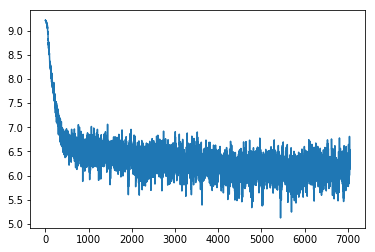

In [64]:
plt.plot(loss_change)

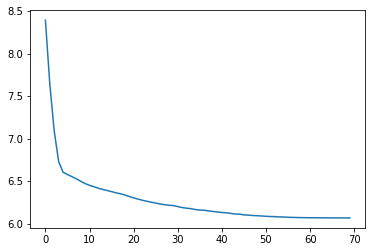

In [65]:
plt.plot(val_loss_change)

Overall the loss is decreasing and everything looks nice!